In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv('../../data/clean_wells.csv')

In [3]:
data = data.drop(columns='Unnamed: 0')

In [4]:
data.head()

,amount_tsh,gps_height,basin,region,population,construction_year,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,status_group,near_pop,level,has_static,has_year
0,6000.0,1390,Lake Nyasa,Iringa,109,1999,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,functional,True,above,True,True
1,0.0,1399,Lake Victoria,Mara,280,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,True,above,False,True
2,25.0,686,Pangani,Manyara,250,2009,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,functional,True,above,True,True
3,0.0,263,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,vwc,user-group,never pay,good,dry,borehole,groundwater,communal standpipe,non functional/needs repair,True,above,False,True
4,0.0,0,Lake Victoria,Kagera,0,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,False,level,False,False


## MODELO TIME!!

In [5]:
X = data.drop(columns = ['status_group', 'amount_tsh', 'gps_height', 'population', 'construction_year', 'has_year'])
y = data['status_group']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [6]:
y_map = {'functional': 1, 'non functional/needs repair':0}
y_train_fix = y_train.map(y_map)


In [7]:
y_test_fix = y_test.map(y_map)

- creating a seperate cat cols and num cols
- scaling and ohe
- creating pipeline to make models

In [8]:
X.head(3)

,basin,region,extraction_type_class,management,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,near_pop,level,has_static
0,Lake Nyasa,Iringa,gravity,vwc,user-group,annually,good,enough,spring,groundwater,communal standpipe,True,above,True
1,Lake Victoria,Mara,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,True,above,False
2,Pangani,Manyara,gravity,vwc,user-group,per bucket,good,enough,dam,surface,communal standpipe,True,above,True


In [9]:
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

In [10]:
cat_cols

Index(['basin', 'region', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'quality_group', 'quantity_group',
       'source_type', 'source_class', 'waterpoint_type_group', 'level'],
      dtype='object')

In [11]:
num_cols

Index(['near_pop', 'has_static'], dtype='object')

In [12]:
num_trans = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])
cat_trans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
])

In [13]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, num_cols),
    ('cat', cat_trans, cat_cols)
])

In [14]:
preprocessor.fit(X_train)
X_tr_pr = preprocessor.transform(X_train)
X_te_pr = preprocessor.transform(X_test)

## Decision Tree Model

In [15]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_tr_pr, y_train_fix)

dt_scores_cv = cross_val_score(dt, X_tr_pr, y_train_fix, cv=5)

print(f"Median Train score: {np.median(dt_scores_cv):.4f} (+/- {np.std(dt_scores_cv):.4f})")

print('Test Score:', dt.score(X_te_pr, y_test_fix))

Median Train score: 0.7751 (+/- 0.0075)
Test Score: 0.774074074074074


In [16]:
dt.predict(X_te_pr)

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

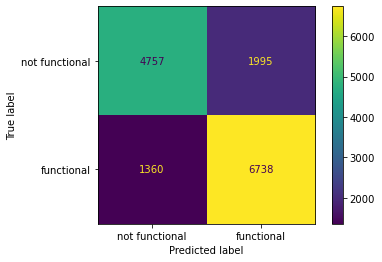

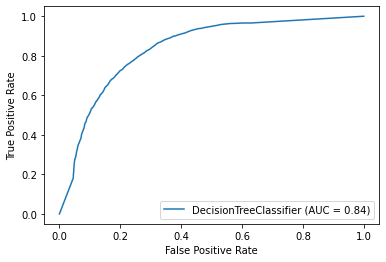

In [17]:
plot_confusion_matrix(dt, X_te_pr, y_test_fix, display_labels=['not functional', 'functional']);
plot_roc_curve(dt, X_te_pr, y_test_fix)

## AdaBoost

In [18]:
ada = AdaBoostClassifier(random_state=42)

ada.fit(X_tr_pr, y_train_fix)

print(f"Train Score: {ada.score(X_tr_pr, y_train_fix)}")
print(f"Test Score: {ada.score(X_te_pr, y_test_fix)}")

Train Score: 0.7268462401795736
Test Score: 0.7248484848484849


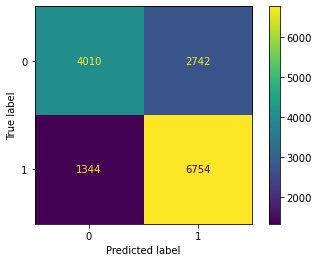

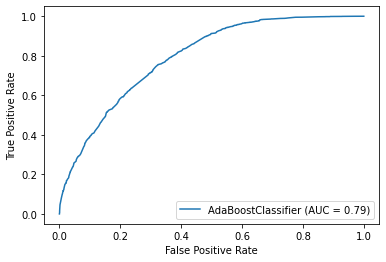

In [19]:
plot_confusion_matrix(ada, X_te_pr, y_test_fix);
plot_roc_curve(ada, X_te_pr, y_test_fix)

## Random Forest

In [20]:
rfc = RandomForestClassifier(random_state=42, n_estimators=150, max_depth=30, min_samples_leaf=7)
rfc.fit(X_tr_pr, y_train_fix)

rfc_scores = cross_val_score(estimator=rfc, X=X_tr_pr, y=y_train_fix, cv=5)

print(f"Train Median score: {np.median(rfc_scores):.4f} (+/- {np.std(rfc_scores):.4f})")
print('Test Score:',rfc.score(X_te_pr, y_test_fix))

Train Median score: 0.7734 (+/- 0.0083)
Test Score: 0.7744107744107744


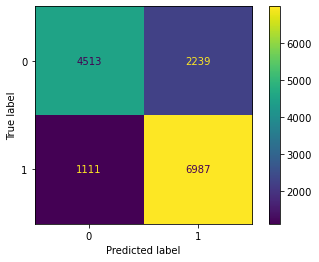

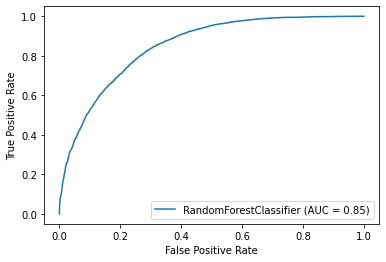

In [21]:
plot_confusion_matrix(rfc, X_te_pr, y_test_fix);
plot_roc_curve(rfc, X_te_pr, y_test_fix)

## XGBOOST

- For a more robust fix, you will need to run hyperparamter tuning search. Especially you should try different values of : scale_pos_weight, alpha, lambda, gamma and min_child_weight. Since they are the ones with the most impact on how conservative the model is going to be.

**best f1 score params**

precision ----
xgb_model = xgb.XGBClassifier(scale_pos_weight=0.1, reg_alpha=5, min_child_weight=0.1, random_state=42)

f1, roc_auc----
xgb_model = xgb.XGBClassifier(scale_pos_weight=5, reg_alpha=0.1, min_child_weight=0.1, random_state=42)

In [58]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=5, reg_alpha=0.1, min_child_weight=0.1, random_state=42)

xgb_model.fit(X_tr_pr, y_train_fix)

print(f"Train Score: {xgb_model.score(X_tr_pr, y_train_fix)}")
print(f"Test Score: {xgb_model.score(X_te_pr, y_test_fix)}")

Train Score: 0.74996632996633
Test Score: 0.7349494949494949


In [59]:
(len(X_te_pr) - 1339 - 81)/len(X_te_pr)

0.9043771043771044

In [157]:
915 / len(X_te_pr)

0.06161616161616162

In [158]:
len(X_te_pr)

14850

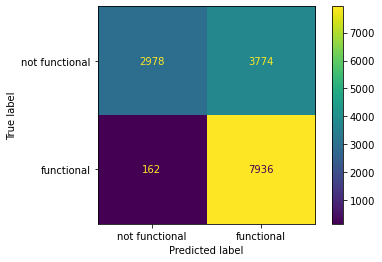

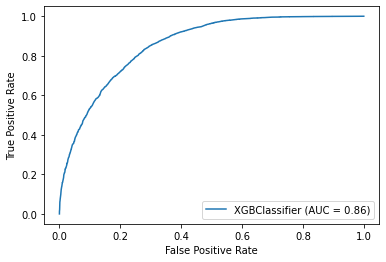

In [61]:
plot_confusion_matrix(xgb_model, X_te_pr, y_test_fix, display_labels=['not functional', 'functional']);
plot_roc_curve(xgb_model, X_te_pr, y_test_fix)

In [62]:
train_probs = xgb_model.predict_proba(X_tr_pr)[:,1]
test_probs = xgb_model.predict_proba(X_te_pr)[:,1]

In [63]:
train_preds = xgb_model.predict(X_tr_pr)
test_preds = xgb_model.predict(X_te_pr)

In [64]:
y_train_compare = pd.DataFrame(y_train_fix).rename(columns={'Yield':'Actual'})
y_train_compare['Predicted'] = train_preds
y_train_compare['Predicted Probabilities'] = train_probs

In [65]:
y_train_compare.head()

,status_group,Predicted,Predicted Probabilities
24947,0,1,0.825326
22630,1,1,0.929296
13789,1,1,0.943925
15697,1,1,0.891908
22613,0,0,0.060277


In [66]:
col_names = ['threshold', 'mean_train_pred', 'mean_test_pred', 'train_acc', 'test_acc', 
             'train_prec', 'test_prec', 'train_rec', 'test_rec', 'train_f1', 'test_f1']
metrics_df = pd.DataFrame(columns=col_names)

for x in np.arange(train_probs.min(), train_probs.max(), 0.01):
    threshold = x
    
    y_pred_train = np.where(train_probs > x, 1, 0)
    y_pred_test = np.where(test_probs > x, 1, 0)
    
    train_acc = accuracy_score(y_train_fix, y_pred_train)
    test_acc = accuracy_score(y_test_fix, y_pred_test)
    
    train_prec = precision_score(y_train_fix, y_pred_train)
    test_prec = precision_score(y_test_fix, y_pred_test)
    
    train_rec = recall_score(y_train_fix, y_pred_train)
    test_rec = recall_score(y_test_fix, y_pred_test)
    
    train_f1 = f1_score(y_train_fix, y_pred_train)
    test_f1 = f1_score(y_test_fix, y_pred_test)
    
    placeholder = [threshold, y_pred_train.mean(), y_pred_test.mean(),
                   train_acc, test_acc, train_prec, test_prec,
                   train_rec, test_rec, train_f1, test_f1]
    
    sample_S = pd.Series(placeholder, index=col_names)
    metrics_df = metrics_df.append(sample_S, ignore_index=True)

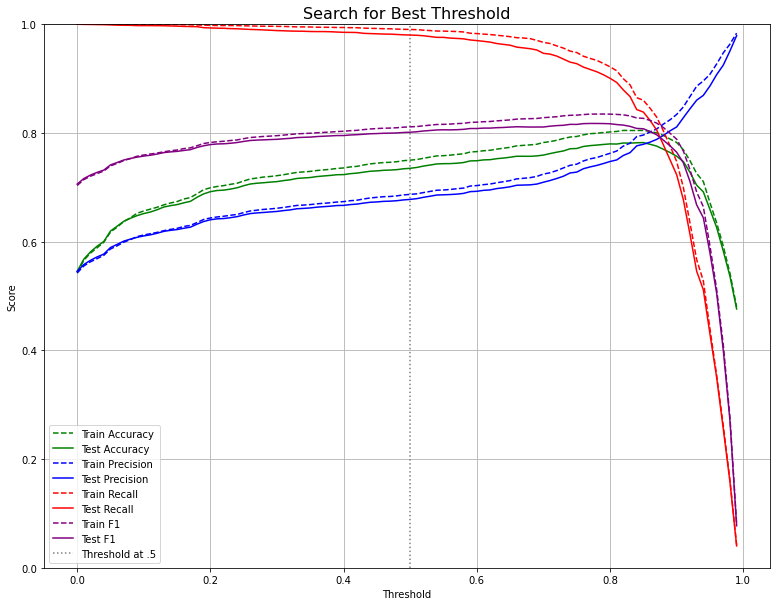

In [67]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_title("Search for Best Threshold", fontsize=16)

ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.grid(True)

ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = metrics_df['threshold'].values

# Currently have all the train metrics hashed out - can unhash to visualize

ax.plot(X_axis, metrics_df['train_acc'], ls='--', color='g', label='Train Accuracy')
ax.plot(X_axis, metrics_df['test_acc'], color='g', label='Test Accuracy')

ax.plot(X_axis, metrics_df['train_prec'], ls='--', color='b', label='Train Precision')
ax.plot(X_axis, metrics_df['test_prec'], color='b', label='Test Precision')

ax.plot(X_axis, metrics_df['train_rec'], ls='--', color='r', label='Train Recall')
ax.plot(X_axis, metrics_df['test_rec'], ls='-', color='r', label='Test Recall')

ax.plot(X_axis, metrics_df['train_f1'], ls='--', color='purple', label='Train F1')
ax.plot(X_axis, metrics_df['test_f1'], ls='-', color='purple', label='Test F1')

ax.vlines(.5, 0, 1, color='gray', ls='dotted', label='Threshold at .5')

plt.legend()
plt.show()

In [150]:
adj_train_preds = np.where(train_probs > .92, 1, 0)
adj_test_preds = np.where(test_probs > .92, 1, 0)

In [151]:
confusion_matrix(y_train_fix, adj_train_preds)

array([[18036,  2353],
       [ 8832, 15329]], dtype=int64)

In [152]:
confusion_matrix(y_test_fix, adj_test_preds)

array([[5837,  915],
       [3131, 4967]], dtype=int64)

In [153]:
# Now evaluate:
print(f"Old Train F1: {f1_score(y_train_fix, train_preds)}")
print(f"Old Test F1: {f1_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train F1: {f1_score(y_train_fix, adj_train_preds)}")
print(f"New Test F1: {f1_score(y_test_fix, adj_test_preds)}")

Old Train F1: 0.8111809875747971
Old Test F1: 0.801292407108239
********************
New Train F1: 0.7326912506273451
New Test F1: 0.7105865522174535


In [154]:
print(f"Old Train precision: {precision_score(y_train_fix, train_preds)}")
print(f"Old Test precision: {precision_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train precision: {precision_score(y_train_fix, adj_train_preds)}")
print(f"New Test precision: {precision_score(y_test_fix, adj_test_preds)}")

Old Train precision: 0.6869258153422141
Old Test precision: 0.6777113578138343
********************
New Train precision: 0.8669268182332316
New Test precision: 0.8444406664399864


In [155]:
print(f"Old Train accuracy: {accuracy_score(y_train_fix, train_preds)}")
print(f"Old Test accuracy: {accuracy_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train accuracy: {accuracy_score(y_train_fix, adj_train_preds)}")
print(f"New Test accuracy: {accuracy_score(y_test_fix, adj_test_preds)}")

Old Train accuracy: 0.74996632996633
Old Test accuracy: 0.7349494949494949
********************
New Train accuracy: 0.7489337822671156
New Test accuracy: 0.7275420875420875


In [156]:
print(f"Old Train roc_auc: {roc_auc_score(y_train_fix, train_preds)}")
print(f"Old Test roc_auc: {roc_auc_score(y_test_fix, test_preds)}")
print("*"*20)
print(f"New Train roc_auc: {roc_auc_score(y_train_fix, adj_train_preds)}")
print(f"New Test roc_auc: {roc_auc_score(y_test_fix, adj_test_preds)}")

Old Train roc_auc: 0.7277338744329135
Old Test roc_auc: 0.7105247814392179
********************
New Train roc_auc: 0.759523425371719
New Test roc_auc: 0.7389229604700243


## GridSearch XGBOOST

In [24]:
xgb_cv = Pipeline(steps=[
    ('preporcessor', preprocessor),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

In [39]:
param_xgb = {
    'xgb__scale_pos_weight':[1, 5, 8],
    'xgb__reg_alpha': [0.01, 0.05, .1, 0.5],
    'xgb__min_child_weight': [0.01, 0.05, 0.5]
}

In [40]:
# 'xgb__reg_alpha': [],
# 'xgb__reg_lambda': [],
# 'xgb__gamma': [],

In [41]:
# gs_xgb = GridSearchCV(xgb_cv, param_xgb, cv=5, verbose=1, scoring='f1')

# gs_xgb.fit(X_train, y_train_fix)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  9.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preporcessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['near_pop', 'has_static'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         Index(['basin', 'regi

In [42]:
# gs_xgb.best_params_

{'xgb__min_child_weight': 0.05,
 'xgb__reg_alpha': 0.5,
 'xgb__scale_pos_weight': 1}

## Averaging best models

In [80]:
estimators = [
    ('rfc', rfc),
    ('xgb', xgb_model)
]

sr = StackingClassifier(estimators)

sr.fit(X_tr_pr, y_train_fix)

StackingClassifier(estimators=[('rfc',
                                RandomForestClassifier(max_depth=30,
                                                       min_samples_leaf=7,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                      

In [81]:
print(f"Train Score: {sr.score(X_tr_pr, y_train_fix)}")
print(f"Test Score: {sr.score(X_te_pr, y_test_fix)}")

Train Score: 0.8020875420875421
Test Score: 0.7808080808080808


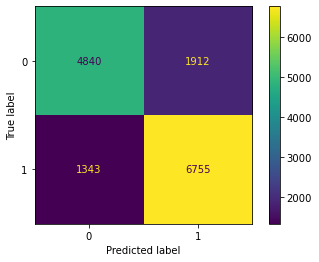

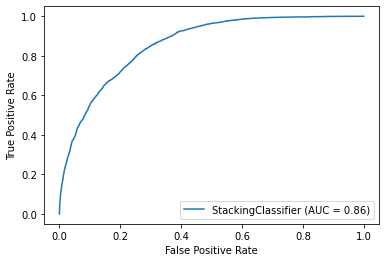

In [82]:
plot_confusion_matrix(sr, X_te_pr, y_test_fix);
plot_roc_curve(sr, X_te_pr, y_test_fix)